Total Images: 2011
Total Labels: 33296
Label Distribution: {'small-vehicle': 5859, 'plane': 3345, 'large-vehicle': 4142, 'ship': 12553, 'harbor': 3803, 'ground-track-field': 79, 'soccer-ball-field': 86, 'tennis-court': 924, 'baseball-diamond': 197, 'swimming-pool': 648, 'roundabout': 138, 'storage-tank': 341, 'basketball-court': 121, 'helicopter': 175, 'bridge': 885}


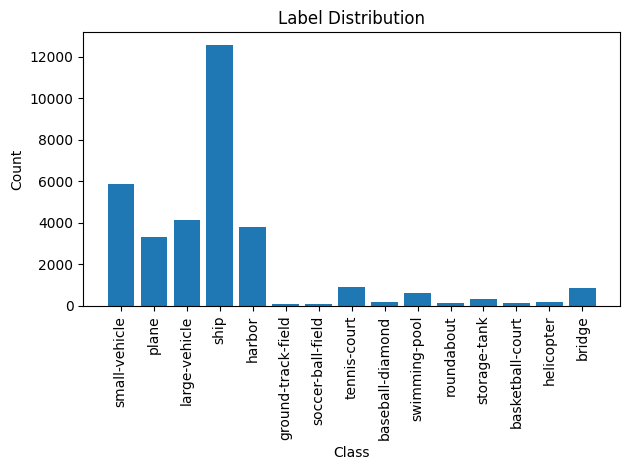

Average Resolution: 640x640


In [4]:
import os
import cv2
from collections import Counter
from matplotlib import pyplot as plt

# Class mapping from your dataset
class_mapping = [
    'baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor',
    'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
    'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'
]

# Paths
images_path = "dataset/valid/images"  # Replace with the path to your images folder
labels_path = "dataset/valid/labels"  # Replace with the path to your labels folder
output_path = "output"  # Replace with the path to save labeled images

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Initialize statistics
label_counter = Counter()
image_stats = []

# Function to draw bounding boxes and labels
def draw_labels(image_path, label_path, output_path):
    # Read the image
    img = cv2.imread(image_path)
    h, w, _ = img.shape
    
    # Parse the label file (YOLO format assumed)
    with open(label_path, 'r') as file:
        labels = file.readlines()
    
    for label in labels:
        cls_id, x, y, width, height = map(float, label.strip().split())
        class_name = class_mapping[int(cls_id)]  # Map class ID to name
        label_counter[class_name] += 1
        
        # Convert YOLO format to pixel coordinates
        x1 = int((x - width / 2) * w)
        y1 = int((y - height / 2) * h)
        x2 = int((x + width / 2) * w)
        y2 = int((y + height / 2) * h)
        
        # Draw rectangle and label
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Save the image with labels
    cv2.imwrite(os.path.join(output_path, os.path.basename(image_path)), img)

# Process dataset
for filename in os.listdir(images_path):
    if filename.endswith(('.jpg', '.png')):
        image_path = os.path.join(images_path, filename)
        label_path = os.path.join(labels_path, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        
        if os.path.exists(label_path):
            draw_labels(image_path, label_path, output_path)
            image_stats.append(cv2.imread(image_path).shape[:2])  # Append (height, width)

# Display statistics
print(f"Total Images: {len(image_stats)}")
print(f"Total Labels: {sum(label_counter.values())}")
print(f"Label Distribution: {dict(label_counter)}")

# Plot distribution of labels
plt.bar(label_counter.keys(), label_counter.values())
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Image resolution statistics
image_heights, image_widths = zip(*image_stats)
print(f"Average Resolution: {sum(image_widths) // len(image_widths)}x{sum(image_heights) // len(image_heights)}")


### This shows the absolute amount of accurences of each class throughout the image labels

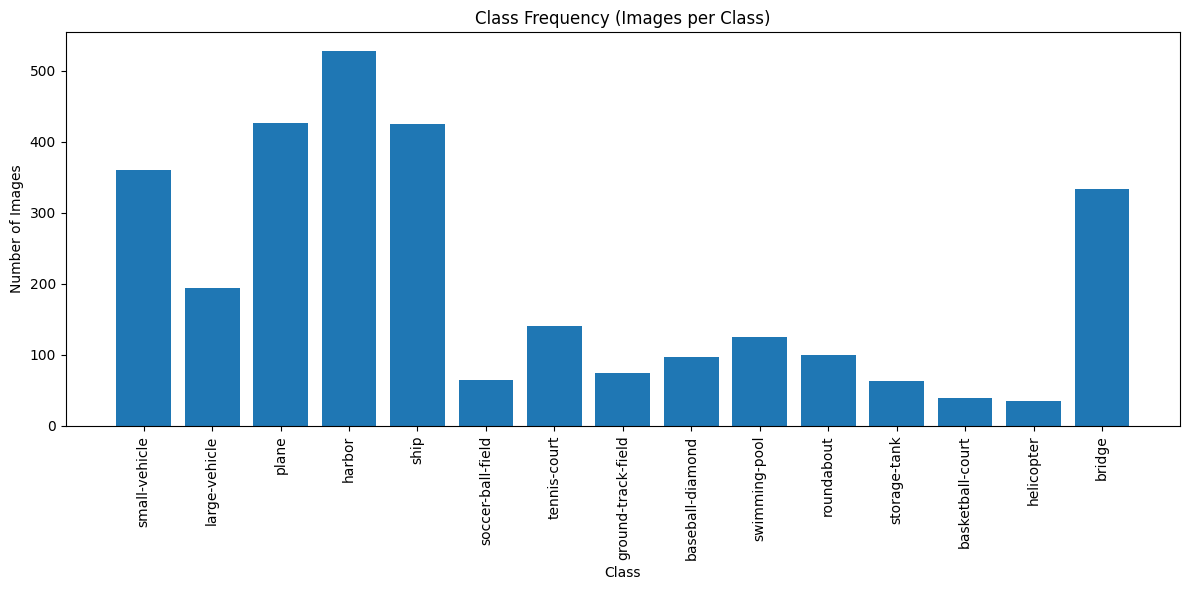

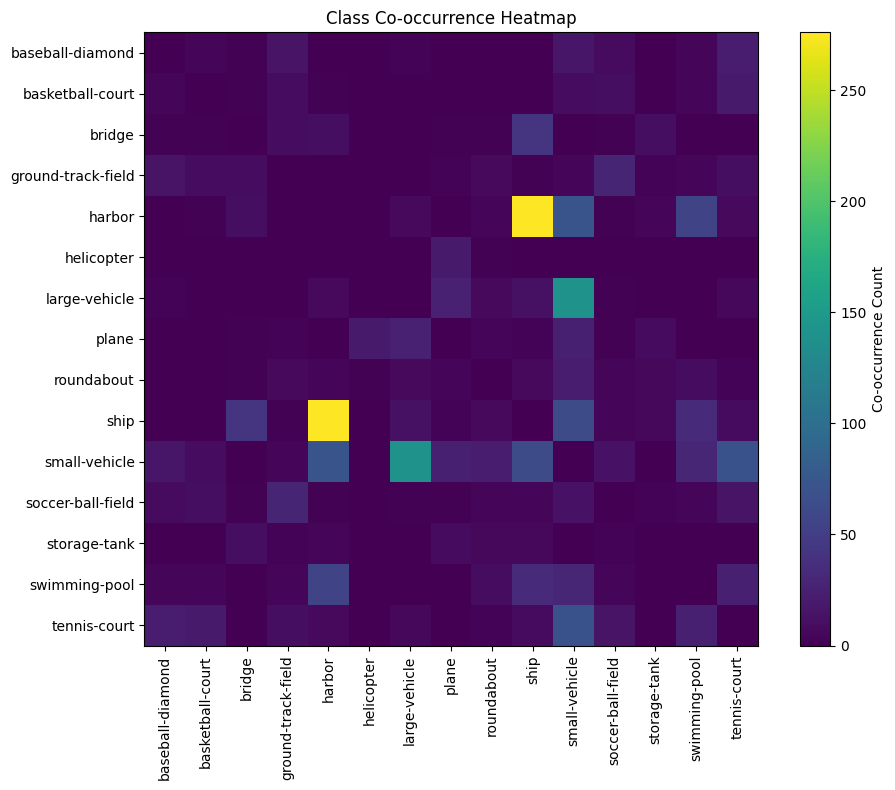

Bounding box statistics saved to bounding_box_statistics.csv


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt

# Class mapping from your dataset (from data.yaml)
class_mapping = [
    'baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor',
    'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
    'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'
]

# Paths (update these based on your dataset location)
labels_path = "dataset/valid/labels"  # Replace with the path to your labels folder

# Initialize analysis structures
co_occurrence = Counter()
class_frequency = Counter()
bbox_stats = {cls: [] for cls in class_mapping}

# Process each label file
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        label_path = os.path.join(labels_path, filename)
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Extract class IDs and bounding boxes
        image_classes = set()
        for line in lines:
            cls_id, x, y, width, height = map(float, line.strip().split())
            cls_name = class_mapping[int(cls_id)]
            image_classes.add(cls_name)
            
            # Store bounding box size (width * height) in percentage of the image area
            bbox_stats[cls_name].append(width * height)
        
        # Update co-occurrence counts
        for combo in itertools.combinations(sorted(image_classes), 2):
            co_occurrence[combo] += 1
        
        # Update class frequency
        for cls in image_classes:
            class_frequency[cls] += 1

# Convert co-occurrence data to a DataFrame
co_occurrence_df = pd.DataFrame(
    [{'Class Pair': pair, 'Count': count} for pair, count in co_occurrence.items()]
).sort_values(by='Count', ascending=False)

# Plot class frequency
plt.figure(figsize=(12, 6))
plt.bar(class_frequency.keys(), class_frequency.values())
plt.title("Class Frequency (Images per Class)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot co-occurrence heatmap
class_names = list(class_mapping)
heatmap = np.zeros((len(class_names), len(class_names)))

for (cls1, cls2), count in co_occurrence.items():
    i, j = class_names.index(cls1), class_names.index(cls2)
    heatmap[i, j] = count
    heatmap[j, i] = count  # Symmetric matrix

plt.figure(figsize=(10, 8))
plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Co-occurrence Count")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.title("Class Co-occurrence Heatmap")
plt.tight_layout()
plt.show()

# Bounding box statistics
bbox_summary = {
    cls: {
        'Average Size (percentage)': np.mean(areas) * 100 if areas else 0,
        'Max Size (percentage)': np.max(areas) * 100 if areas else 0,
        'Min Size (percentage)': np.min(areas) * 100 if areas else 0
    }
    for cls, areas in bbox_stats.items()
}
bbox_summary_df = pd.DataFrame(bbox_summary).T

# Save results to a CSV file
output_csv = "bounding_box_statistics.csv"
bbox_summary_df.to_csv(output_csv)
print(f"Bounding box statistics saved to {output_csv}")


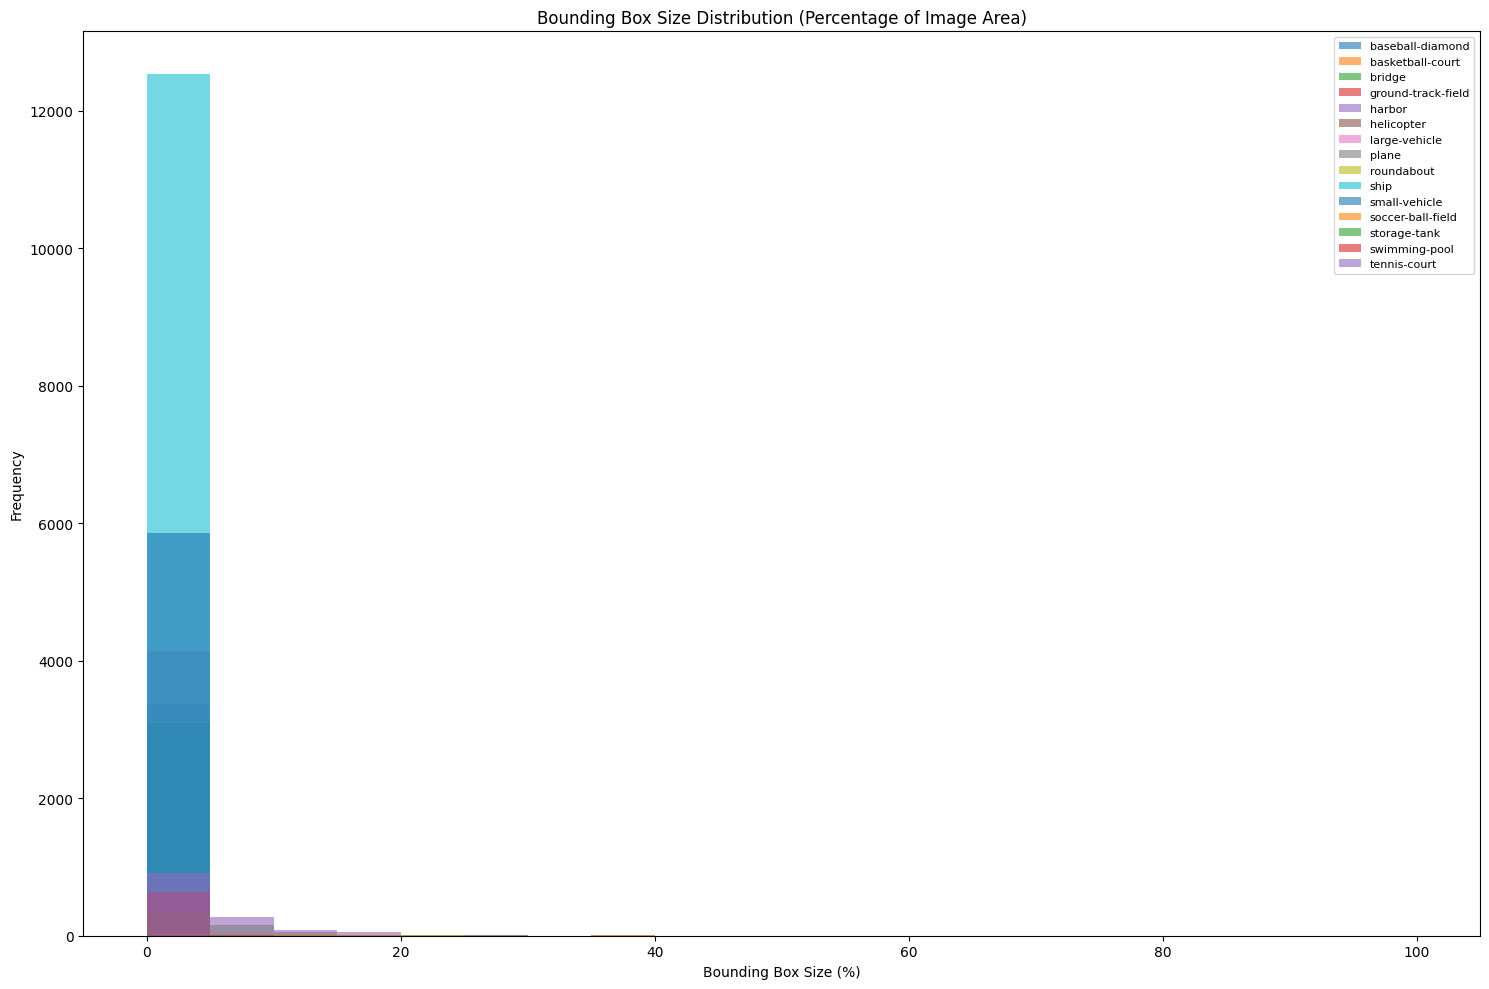

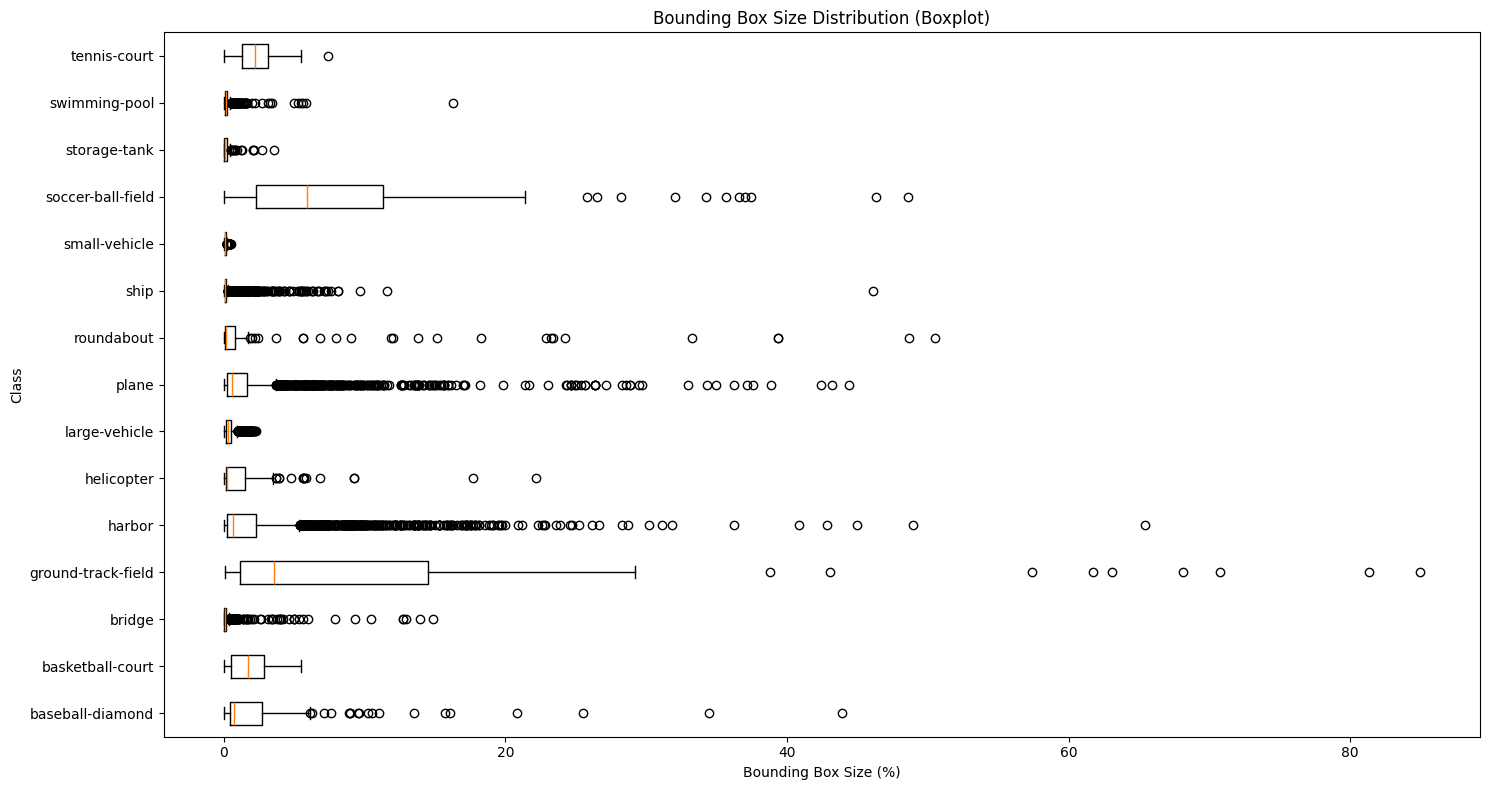

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt

# Class mapping from your dataset
class_mapping = [
    'baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor',
    'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
    'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'
]

# Paths (update these based on your dataset location)
labels_path = "dataset/valid/labels"  # Replace with the path to your labels folder

# Initialize analysis structures
bbox_stats = {cls: [] for cls in class_mapping}

# Process each label file
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        label_path = os.path.join(labels_path, filename)
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Extract class IDs and bounding boxes
        for line in lines:
            cls_id, x, y, width, height = map(float, line.strip().split())
            cls_name = class_mapping[int(cls_id)]
            
            # Store bounding box size (width * height) in percentage of the image area
            bbox_stats[cls_name].append(width * height * 100)  # Convert to percentage

# Visualize bounding box sizes
plt.figure(figsize=(15, 10))
for cls, sizes in bbox_stats.items():
    if sizes:  # Only plot classes with data
        plt.hist(sizes, bins=20, alpha=0.6, label=cls, range=(0, 100))

plt.title("Bounding Box Size Distribution (Percentage of Image Area)")
plt.xlabel("Bounding Box Size (%)")
plt.ylabel("Frequency")
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

# Boxplot for Bounding Box Sizes
plt.figure(figsize=(15, 8))
boxplot_data = [sizes for sizes in bbox_stats.values() if sizes]
plt.boxplot(boxplot_data, labels=[cls for cls, sizes in bbox_stats.items() if sizes], vert=False)
plt.title("Bounding Box Size Distribution (Boxplot)")
plt.xlabel("Bounding Box Size (%)")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


For each class:

**Box:**

    - Represents the interquartile range (IQR), which contains the middle 50% of the bounding box   sizes.

    - The orange line inside the box represents the median (the middle value of bounding box sizes).

**Whiskers:**

    - Extend from the box to the minimum and maximum values within 1.5 times the IQR.

    - Beyond this range, data points are considered outliers.

**Dots (Outliers):**    

    - Points outside the whiskers are outliers, indicating unusually small or large bounding box sizes.




In [7]:
import os
import hashlib
from collections import defaultdict

# Paths
images_path = "dataset/valid/images"  # Replace with your images folder path
labels_path = "dataset/valid/labels"  # Replace with your labels folder path

# Function to calculate hash for a file
def calculate_file_hash(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Detect duplicate files in a folder
def detect_duplicates(folder_path, file_ext):
    hashes = defaultdict(list)
    for filename in os.listdir(folder_path):
        if filename.endswith(file_ext):
            file_path = os.path.join(folder_path, filename)
            file_hash = calculate_file_hash(file_path)
            hashes[file_hash].append(filename)
    return {h: files for h, files in hashes.items() if len(files) > 1}

# Print and optionally remove duplicates
def handle_duplicates(duplicates, folder_path, remove=False):
    if duplicates:
        print(f"Duplicate Files in {folder_path}:")
        for file_hash, files in duplicates.items():
            print(f"Hash: {file_hash}")
            for i, file in enumerate(files):
                print(f"  {i+1}. {file}")
            # Optionally delete duplicates (keep the first file)
            if remove:
                for file in files[1:]:
                    os.remove(os.path.join(folder_path, file))
                    print(f"Removed: {file}")
    else:
        print(f"No duplicates found in {folder_path}.")

# Detect duplicate images
print("Checking for duplicate images...")
image_duplicates = detect_duplicates(images_path, (".jpg", ".jpeg", ".png"))
handle_duplicates(image_duplicates, images_path, remove=False)

# Detect duplicate labels
print("\nChecking for duplicate labels...")
label_duplicates = detect_duplicates(labels_path, ".txt")
handle_duplicates(label_duplicates, labels_path, remove=False)

# Summary
print("\nDuplicate Check Complete.")
print("Use remove=True in handle_duplicates() to delete duplicates.")


Checking for duplicate images...
No duplicates found in dataset/valid/images.

Checking for duplicate labels...
No duplicates found in dataset/valid/labels.

Duplicate Check Complete.
Use remove=True in handle_duplicates() to delete duplicates.
